In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import os
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import random
from scipy.ndimage.interpolation import rotate
from scipy import misc
from planar import BoundingBox
from PIL import ImageEnhance
from PIL import Image

%matplotlib inline
print "Done"

Done


In [2]:
# Load the training dataset metadata
# Make sure to run the DataProcessing.ipynb to get this files
training_metadata = np.load("train_metadata.npy")
training_metadata = training_metadata[()]

In [3]:
# models value
N_CHANNELS=1
NUM_LABELS=11 # 0-9 the blank character
SEED=987
MODEL_INPUT_IMAGE_SIZE=54
INITIAL_LEARNING_RATE = 5e-5        # Initial learning rate.
MODEL_FOLDER_NAME="model"
SHUFFLE_DATASET_PER_EPOCH=5
BATCH_SIZE=86
TOTAL_NUM_OF_EPOCHES = 100
MAX_SEQUENCE_LENGTH=5
PIXEL_DEPTH=255.0
MINIBATCH_EVAL_STEPS=500

In [4]:
# Crop an image from a random location
# Input: image's: array 
#       Width: Image width
#       Height: Image's height 
# Output: randomly cropped image
def random_crop(img,width,height):
    aa = random.randrange(0,11)
    cc = random.randrange(0,11)
    return img[aa:(width+aa), cc:(height+cc)]  

In [5]:
# Read image from disk
# Input: Image path
def read_image_from_disk(image_path):
    # read the image from disk
    try:
        original_img = misc.imread("./" + image_path, mode ="L")
    except IOError as e:
        print("Oops! Problem reading that image, lets skip it.")
        original_img = None
    return original_img

In [6]:
# Randomly rotate an image from -degree to +degree
# Input: img: array, image to be rotated
#        degrees: float, degree in which the image will be rotated 
# Output: array, rotated image
def rotate_img(img, degrees):
    # get a random value 
    d = random.randrange(-degrees,degrees,2)
    
    rotated = rotate(img, d, reshape=False, mode="nearest")
    return rotated

In [7]:
# Randomly apply Brightness, Contrast and Bluring changes to an image
# Input: img: array, image to be processed
# Output: enhanced image
def distort_image(img):
    pil_image = Image.fromarray(img)

    # appy random Brightness
    factor = random.uniform(0.4, 1.0)
    enhancer = ImageEnhance.Brightness(pil_image)
    distorted_image = enhancer.enhance(factor)

    # apply random Contrast
    factor = random.uniform(0.4, 1.0)
    enhancer = ImageEnhance.Contrast(distorted_image)
    distorted_image = enhancer.enhance(factor)

    # apply random blur
    sharpness_factor = random.uniform(0.2, 1.0)
    enhancer = ImageEnhance.Sharpness(distorted_image)
    distorted_image = enhancer.enhance(sharpness_factor)

    # convert to numpy image
    img = np.array(distorted_image)
    return img

In [8]:
# Create a batch array containing images to be fed into the neural network
# Input: iteration_step: int, current training iteration
#        batch_size: int desired size of the image batch
#        image_size: int, size of the images in the batch
#        image_names: array, data processed by the DataProcessing.ipynb
#        images_bboxes: array, data processed by the DataProcessing.ipynb
#        expand_bbox: bool, apply bbox 30% expantion before random cropping
#        training: bool, apply image processing algorithms
def get_batch_data_and_labels(iteration_step, batch_size, image_size, image_names, label_names, images_bboxes, expand_bbox=False, training=False):
    
    if len(label_names) % batch_size != 0:
        print "Error, please provide a batch_size value that is factor of", len(label_names)
    
    dataset_id = 0
    dataset = np.zeros(shape=(batch_size, image_size, image_size, N_CHANNELS), dtype=np.float32)
    labels = np.zeros(shape=(batch_size, MAX_SEQUENCE_LENGTH), dtype=np.int8)
    offset = (iteration_step * batch_size) % (len(label_names))
    
    for img_id in range(offset, offset + batch_size):

        # get the image file name and label
        img_name = image_names[img_id]
        img_labels = label_names[img_id]
        
        # if the image has more than [MAX_SEQUENCE_LENGTH] digits, discard it
        if len(img_labels) > MAX_SEQUENCE_LENGTH:
            print "Discarding image:", img_name, "\tMore than:", MAX_SEQUENCE_LENGTH, "digits."
            continue
        
        original_img = read_image_from_disk(img_name)
        if original_img is None:
            continue

        # get the image size
        img_h = original_img.shape[0]
        img_w = original_img.shape[1]

        # read the bbox data
        aa, bb, cc, dd = map(int, images_bboxes[img_id])

        # create bbox
        bbox = BoundingBox([(cc,aa), (dd,bb)])

        # make the bboxes squared
        if bbox.width > bbox.height:
            needed_value =  bbox.width - bbox.height
            max_height = min(aa, (img_h-bb)) 
            if (needed_value) <= max_height:
                bbox = bbox.inflate((0, needed_value))
            else:
                bbox = bbox.inflate((0,max_height)) 
        elif bbox.width < bbox.height:
            max_width = min(cc, (img_w-dd)) 
            needed_value =  bbox.height - bbox.width
            if (needed_value) <= max_width:
                bbox = bbox.inflate((needed_value,0))
            else:
                bbox = bbox.inflate((max_width,0)) 
    
        # try to expand the bbox to a maximum of 30%
        # get the maximum height and width size the bbox can expand to
        max_height = min(aa, (img_h-bb)) 
        
        if dd > img_w: dd = img_w
        max_width = min(cc, (img_w-dd))
        
        if expand_bbox == True:
            # get the measures for a 30% increase
            width_expand = bbox.width * 0.3
            height_expand = bbox.height * 0.3

            # if the bbox can increase to more than 30%, make it be 30%
            if max_height > height_expand:
                max_height = height_expand
            if max_width > width_expand:
                max_width = width_expand

            # get the max value the bbox can expand equally in both side
            value = min(max_height, max_width)
            bbox = bbox.inflate(value)
            ## end expand ##

            if aa < 0:
                exit(1)
        
        # get the bbox individual values
        cc, aa = map(int,list(bbox.min_point))
        dd, bb = map(int,list(bbox.max_point))
    
        if training == True:
            r = random.randrange(0, 2)
            if r == 1:
                original_img = rotate_img(original_img, degrees=20)
    
        # crop and resize the images to the bboxes
        img = original_img[aa:bb, cc:dd]   

        if training == True:
            img = distort_image(img)
        
        try:
            if training == True:
                expanding_factor = 10
                img = misc.imresize(img,(image_size + expanding_factor, image_size + expanding_factor))
                img = random_crop(img, image_size, image_size)
            else:
                img = misc.imresize(img,(image_size, image_size))
                
            # normalize the image
            img = (img - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH   
            dataset[dataset_id] = img.reshape(image_size,image_size,N_CHANNELS)
            
        except ValueError as e:
            print "Bbox:", aa, bb, cc, dd
            print "Image Index: ", img_id
            print "Image shape:", img.shape

        labels[dataset_id] = img_labels
        dataset_id += 1

    return dataset, labels


In [9]:
def randomize(dataset, permutation):
  shuffled_dataset = dataset[permutation]
  return shuffled_dataset

In [10]:
# Shuffle dataset 
# Input: train_image_names: array, data processed by the DataProcessing.ipynb
#        train_labels: array, data processed by the DataProcessing.ipynb
#        train_bboxes: array, data processed by the DataProcessing.ipynb
#        train_n_bboxes: array, data processed by the DataProcessing.ipynb
# Output: Shuffled datasets
def shuffle_dataset(train_image_names, train_labels, train_bboxes, train_n_bboxes):
    permutation = np.random.permutation(train_image_names.shape[0])

    # randomize the dataset
    train_image_names = randomize(train_image_names, permutation)
    train_labels = randomize(train_labels, permutation)
    train_bboxes = randomize(train_bboxes, permutation)
    train_n_bboxes = randomize(train_n_bboxes, permutation)
    return train_image_names, train_labels, train_bboxes, train_n_bboxes

In [11]:
# Display grid of images at random
# Input: dataset: array, images to be shown
#        labels: arrays, imagess labels'
def display_images_at_random(dataset, labels):
    f, axarr = plt.subplots(3, 4, figsize=(14,10))
    
    for i in range(3):
        for j in range(4):
            img_rand_index = random.randrange(0,dataset.shape[0])
            img  = dataset[img_rand_index]
            axarr[i, j].imshow(img.reshape(img.shape[0],img.shape[1]), cmap=plt.cm.Greys);
            axarr[i, j].set_title('Label: ' + str(labels[img_rand_index]) + " ID: " + str(img_rand_index))

    plt.show()

In [12]:
train_image_names = training_metadata["file_names"]
train_labels = training_metadata["labels"]
train_bboxes = training_metadata["bboxes"]
train_n_bboxes = training_metadata["n_bboxes"]

In [13]:
train_image_names = np.array(train_image_names)
train_labels = np.array(train_labels)
train_bboxes = np.array(train_bboxes)
train_n_bboxes = np.array(train_n_bboxes)

In [14]:
# shuffle the dataset before creating the validation set
train_image_names, train_labels, train_bboxes, train_n_bboxes = shuffle_dataset(train_image_names, train_labels, train_bboxes, train_n_bboxes)

In [15]:
# separate a chunck from the training set to create the validation set
VALID_DATASET_SIZE=10004
TRAIN_DATASET_SIZE = len(train_image_names) - VALID_DATASET_SIZE

valid_image_names = train_image_names[:VALID_DATASET_SIZE]
valid_labels = train_labels[:VALID_DATASET_SIZE]
valid_bboxes = train_bboxes[:VALID_DATASET_SIZE]
valid_n_bboxes = train_n_bboxes[:VALID_DATASET_SIZE]

train_image_names =  train_image_names[VALID_DATASET_SIZE:]
train_labels =  train_labels[VALID_DATASET_SIZE:]
train_bboxes =  train_bboxes[VALID_DATASET_SIZE:]
train_n_bboxes =  train_n_bboxes[VALID_DATASET_SIZE:]

In [17]:
valid_dataset, valid_labels = get_batch_data_and_labels(0, VALID_DATASET_SIZE, 54, valid_image_names, valid_labels, valid_bboxes, expand_bbox=True, training=False)

In [18]:
VALID_DATASET_SIZE=valid_dataset.shape[0]

In [19]:
print "Validation set", valid_dataset.shape
print "Validation labels", valid_labels.shape

Validation set (10004, 54, 54, 1)
Validation labels (10004, 5)


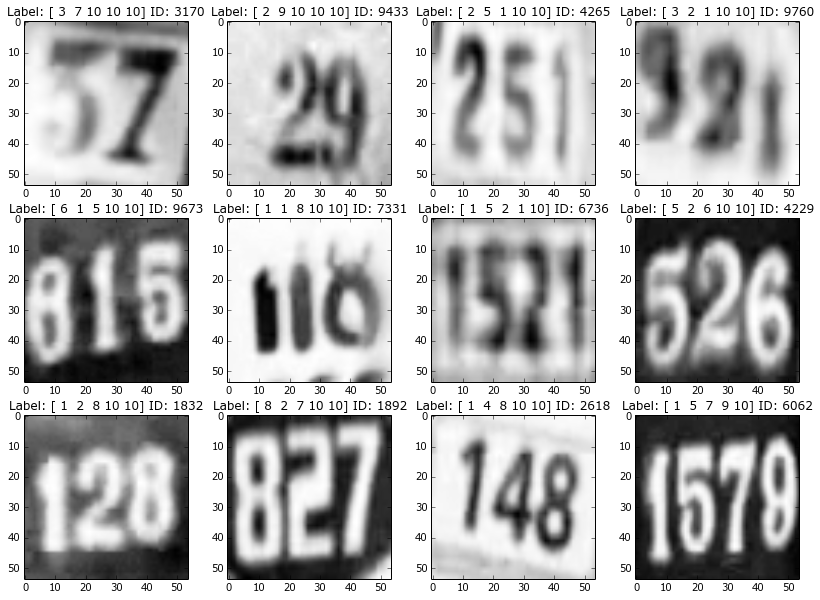

In [20]:
display_images_at_random(valid_dataset, valid_labels)

In [32]:
def weight_variable(name, shape):
  return tf.get_variable(name=name, shape=shape, initializer=tf.contrib.layers.xavier_initializer(seed=SEED))

def weight_conv_variable(name, shape):
  return tf.get_variable(name=name, shape=shape, 
                         initializer=tf.contrib.layers.xavier_initializer_conv2d(seed=SEED))

def bias_variable(shape):
  initial = tf.zeros_initializer(shape=shape, dtype=tf.float32)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x, strides=[1, 2, 2, 1]):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=strides, padding='SAME')

In [33]:
x = tf.placeholder(tf.float32, shape=[None, MODEL_INPUT_IMAGE_SIZE, MODEL_INPUT_IMAGE_SIZE, N_CHANNELS], name="input_placeholder")
y_ = tf.placeholder(tf.int32, shape=[None, MAX_SEQUENCE_LENGTH], name="labels_placeholder")

tf_valid_dataset = tf.placeholder(tf.float32, shape=[None, MODEL_INPUT_IMAGE_SIZE, MODEL_INPUT_IMAGE_SIZE, N_CHANNELS], name="test_placeholder")

In [34]:
# Variables definitions
CONV1_DEPTH=16
W_conv1 = weight_conv_variable("conv1", [5, 5, N_CHANNELS, CONV1_DEPTH])
b_conv1 = bias_variable([CONV1_DEPTH])

CONV2_DEPTH=32
W_conv2 = weight_conv_variable("conv2", [5, 5, CONV1_DEPTH, CONV2_DEPTH])
b_conv2 = bias_variable([CONV2_DEPTH])

CONV3_DEPTH=48
W_conv3 = weight_conv_variable("conv3", [5, 5, CONV2_DEPTH, CONV3_DEPTH])
b_conv3 = bias_variable([CONV3_DEPTH])

CONV4_DEPTH=64
W_conv4 = weight_conv_variable("conv4", [5, 5, CONV3_DEPTH, CONV4_DEPTH])
b_conv4 = bias_variable([CONV4_DEPTH])

CONV5_DEPTH=80
W_conv5 = weight_conv_variable("conv5", [5, 5, CONV4_DEPTH, CONV5_DEPTH])
b_conv5 = bias_variable([CONV5_DEPTH])

CONV6_DEPTH=96
W_conv6 = weight_conv_variable("conv6", [5, 5, CONV5_DEPTH, CONV6_DEPTH])
b_conv6 = bias_variable([CONV6_DEPTH])

CONV7_DEPTH=112
W_conv7 = weight_conv_variable("conv7", [5, 5, CONV6_DEPTH, CONV7_DEPTH])
b_conv7 = bias_variable([CONV7_DEPTH])

FC1_SIZE = 1024
W_fc1 = weight_variable("fc1", [4 * 4 * CONV7_DEPTH, FC1_SIZE])
b_fc1 = bias_variable([FC1_SIZE])

FC2_SIZE = 1024
W_fc2 = weight_variable("fc2", [FC1_SIZE, FC2_SIZE])
b_fc2 = bias_variable([FC2_SIZE])

FC3_SIZE = 1024
W_fc3 = weight_variable("fc3", [FC2_SIZE, FC3_SIZE])
b_fc3 = bias_variable([FC3_SIZE])

read_output_layer_digit_1 = weight_variable("out1", [FC3_SIZE, NUM_LABELS])
read_output_bias_digit_1 = bias_variable([NUM_LABELS])

read_output_layer_digit_2 = weight_variable("out2", [FC3_SIZE, NUM_LABELS])
read_output_bias_digit_2 = bias_variable([NUM_LABELS])

read_output_layer_digit_3 = weight_variable("out3", [FC3_SIZE, NUM_LABELS])
read_output_bias_digit_3 = bias_variable([NUM_LABELS])

read_output_layer_digit_4 = weight_variable("out4", [FC3_SIZE, NUM_LABELS])
read_output_bias_digit_4 = bias_variable([NUM_LABELS])

read_output_layer_digit_5 = weight_variable("out5", [FC3_SIZE, NUM_LABELS])
read_output_bias_digit_5 = bias_variable([NUM_LABELS])
print "Done"

Done


In [35]:
# model
def model(x_image, training=False):

    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    norm1 = tf.nn.lrn(h_pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')
    if (training == True):
        norm1 = tf.nn.dropout(norm1, 0.85, seed=SEED)
    
    h_conv2 = tf.nn.relu(conv2d(norm1, W_conv2) + b_conv2)
    norm2 = tf.nn.lrn(h_conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
    h_pool2 = max_pool_2x2(norm2, strides=[1,1,1,1])
    if (training == True):
        h_pool2 = tf.nn.dropout(h_pool2, 0.86, seed=SEED)
    
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)
    norm3 = tf.nn.lrn(h_pool3, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm3')
    if (training == True):
        norm3 = tf.nn.dropout(norm3, 0.87, seed=SEED)
    
    h_conv4 = tf.nn.relu(conv2d(norm3, W_conv4) + b_conv4)
    norm4 = tf.nn.lrn(h_conv4, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm4')
    h_pool4 = max_pool_2x2(norm4, strides=[1,1,1,1])
    if (training == True):
        h_pool4 = tf.nn.dropout(h_pool4, 0.88, seed=SEED)
    
    h_conv5 = tf.nn.relu(conv2d(h_pool4, W_conv5) + b_conv5)
    h_pool5 = max_pool_2x2(h_conv5)
    norm5 = tf.nn.lrn(h_pool5, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm5')
    if (training == True):
        norm5 = tf.nn.dropout(norm5, 0.89, seed=SEED)
    
    h_conv6 = tf.nn.relu(conv2d(norm5, W_conv6) + b_conv6)
    norm6 = tf.nn.lrn(h_conv6, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm6')
    h_pool6 = max_pool_2x2(norm6, strides=[1,1,1,1])
    if (training == True):
        h_pool6 = tf.nn.dropout(h_pool6, 0.90, seed=SEED)
    
    h_conv7 = tf.nn.relu(conv2d(h_pool6, W_conv7) + b_conv7)
    h_pool7 = max_pool_2x2(h_conv7)
    norm7 = tf.nn.lrn(h_pool7, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm7')
    if (training == True):
        norm7 = tf.nn.dropout(norm7, 0.91, seed=SEED)
        
    shape = norm7.get_shape().as_list()
    h_pool_flat = tf.reshape(norm7, [-1, shape[1] * shape[2] * shape[3]])
    
    # First fully connected layer
    h_fc1 = tf.nn.relu(tf.matmul(h_pool_flat, W_fc1) + b_fc1)
    if (training == True):
        h_fc1 = tf.nn.dropout(h_fc1, 0.92, seed=SEED)

    # Second fully connected layer
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
    if (training == True):
        h_fc2 = tf.nn.dropout(h_fc2, 0.93, seed=SEED)

    # Third fully connected layer
    h_fc3 = tf.nn.relu(tf.matmul(h_fc2, W_fc3) + b_fc3)
    if (training == True):
        h_fc3 = tf.nn.dropout(h_fc3, 0.94, seed=SEED)

    # digit #1
    digit_1 = tf.matmul(h_fc3, read_output_layer_digit_1) + read_output_bias_digit_1

    # digit #2
    digit_2 = tf.matmul(h_fc3, read_output_layer_digit_2) + read_output_bias_digit_2
    
    # digit #3
    digit_3 = tf.matmul(h_fc3, read_output_layer_digit_3) + read_output_bias_digit_3

    # digit #4
    digit_4 = tf.matmul(h_fc3, read_output_layer_digit_4) + read_output_bias_digit_4

    # digit #5
    digit_5 = tf.matmul(h_fc3, read_output_layer_digit_5) + read_output_bias_digit_5
    
    return digit_1, digit_2, digit_3, digit_4, digit_5

Display some of the images just to make sure everything is fine

In [26]:
# logits = model(x, True)
logits_d1, logits_d2, logits_d3, logits_d4, logits_d5 = model(x, True)

loss_d1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_d1, y_[:,0]))
loss_d2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_d2, y_[:,1]))
loss_d3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_d3, y_[:,2]))
loss_d4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_d4, y_[:,3]))
loss_d5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_d5, y_[:,4]))

# apply L2 regularization of the trained weights
regularizers = (tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(b_fc1) +
                 tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(b_fc2) +
                 tf.nn.l2_loss(W_fc3) + tf.nn.l2_loss(b_fc3))

loss_d1 += 5e-4 * regularizers
loss_d2 += 5e-4 * regularizers
loss_d3 += 5e-4 * regularizers
loss_d4 += 5e-4 * regularizers
loss_d5 += 5e-4 * regularizers

total_loss = loss_d1 + loss_d2 + loss_d3 + loss_d4 + loss_d5

loss_summary = tf.scalar_summary('loss', total_loss)

optimizer = tf.train.AdamOptimizer(INITIAL_LEARNING_RATE, epsilon=1e-05).minimize(total_loss)

# Predictions for the minibatch, validation set and test set.
train_pred = tf.pack([tf.nn.softmax(logits_d1), 
                     tf.nn.softmax(logits_d2),
                     tf.nn.softmax(logits_d3), 
                     tf.nn.softmax(logits_d4),
                     tf.nn.softmax(logits_d5)])
train_pred = tf.transpose(train_pred, perm=[1, 0, 2])

print "Done"

Done


In [36]:
valid_logits_d1, valid_logits_d2, valid_logits_d3, valid_logits_d4, valid_logits_d5 = model(tf_valid_dataset, False)
valid_pred = tf.pack([tf.nn.softmax(valid_logits_d1), 
                     tf.nn.softmax(valid_logits_d2), 
                     tf.nn.softmax(valid_logits_d3), 
                     tf.nn.softmax(valid_logits_d4),
                     tf.nn.softmax(valid_logits_d5)])
valid_pred = tf.transpose(valid_pred, perm=[1, 0, 2])

In [ ]:
# Create a new interactive session that we'll use in
# subsequent code cells.
s = tf.InteractiveSession()

# Use our newly created session as the default for 
# subsequent operations.
s.as_default()

# Merge all the summaries and write them out to /tmp/mnist_logs (by default)
merged = tf.merge_summary([loss_summary])
train_writer = tf.train.SummaryWriter('./summary/' + MODEL_FOLDER_NAME , s.graph)

# Initialize all the variables we defined above.
init = tf.initialize_all_variables()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

s.run(init)

In [37]:
def transcription_accuracy(predictions, labels):
  return 100. - transcription_error(predictions, labels)

In [38]:
def reformat(input_labels):
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    index = 0
    input_labels_one_hot = np.zeros(shape=(input_labels.shape[0], 5, 11), dtype=np.float32)
    for labels in input_labels:
        for l in labels:
            one_hot_array = (np.arange(NUM_LABELS) == labels[:,None]).astype(np.float32)
        input_labels_one_hot[index] = one_hot_array
        index += 1

    return input_labels_one_hot

In [39]:
def transcription_error(predictions, labels):
    res = np.argmax(predictions,2) == np.argmax(labels,2)
    err_count = 0
    id = 0
    for r in res:
        if False in r:
            #print id
            err_count += 1
        id += 1
    return 100.0 * (err_count / float(predictions.shape[0]))

In [ ]:
errors = []
global_step = 0
for epoch in range(TOTAL_NUM_OF_EPOCHES):
    print "Starting epoch:", epoch
    
    for step in range(0, train_image_names.shape[0]/BATCH_SIZE):
        
        batch_data, batch_labels = get_batch_data_and_labels(step, BATCH_SIZE, MODEL_INPUT_IMAGE_SIZE, train_image_names, train_labels, train_bboxes, True, True)
        
        feed_dict = {x: batch_data, y_: batch_labels}
        summary, _, loss, predictions = s.run(
            [merged, optimizer, total_loss, train_pred], feed_dict=feed_dict)
        
        if global_step % 10 == 0:
            train_writer.add_summary(summary, global_step)

        if (global_step % MINIBATCH_EVAL_STEPS == 0):
            print ('Minibatch loss at step %d: %f' % (global_step, loss))
            print ('Minibatch Error: %.1f%%' % transcription_error(predictions, reformat(batch_labels)))
        global_step += 1

    valid_predictions = valid_pred.eval({tf_valid_dataset: valid_dataset})
    valid_error = transcription_error(valid_predictions, reformat(valid_labels))
    errors.append(valid_error)
    print ('Validation Error: %.1f%%' % valid_error)
    print ("End of epoch:", epoch)
    
    if epoch % SHUFFLE_DATASET_PER_EPOCH == 0 and epoch != 0:
        print "Shuffling dataset for the next epoch."
        # shuffle the datast per epoch
        train_image_names, train_labels, train_bboxes, train_n_bboxes = shuffle_dataset(train_image_names, train_labels, train_bboxes, train_n_bboxes)
    
    print ("------------------------------------------")
        
print "Done training"

In [ ]:
# Plot the error across training steps
plt.plot(errors)
plt.ylabel('some numbers')
plt.show()

In [ ]:
# Save the model
saver = tf.train.Saver()
save_path = saver.save(s, "./summary/" + MODEL_FOLDER_NAME + "/model.ckpt")
print("Model saved in file: %s" % save_path)

In [21]:
# Load the testing metadata
# Make sure to run the DataProcessing.ipunb to get this data
testing_metadata = np.load("test_metadata.npy")
testing_metadata = testing_metadata[()]

In [22]:
test_image_names = testing_metadata["file_names"]
test_labels = testing_metadata["labels"]
test_bboxes = testing_metadata["bboxes"]
test_n_bboxes = testing_metadata["n_bboxes"]

test_image_names = np.array(test_image_names)
test_labels = np.array(test_labels)
test_bboxes = np.array(test_bboxes)
test_n_bboxes = np.array(test_n_bboxes)

In [23]:
TEST_DATASET_SIZE = test_image_names.shape[0]
TEST_IMAGE_SIZE=54

In [25]:
test_dataset, test_labels = get_batch_data_and_labels(0, TEST_DATASET_SIZE, TEST_IMAGE_SIZE, test_image_names, test_labels, test_bboxes, expand_bbox=False, training=False)

In [26]:
print "Testing dataset:", test_dataset.shape
print "Testing labels:", test_labels.shape

Testing dataset: (13068, 54, 54, 1)
Testing labels: (13068, 5)


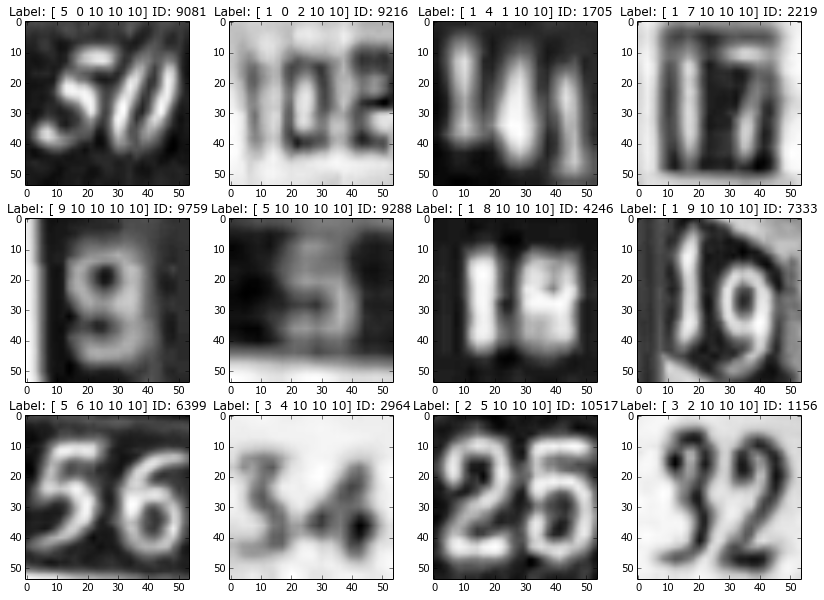

In [27]:
display_images_at_random(test_dataset, test_labels)

Mean: 0.290111
Standard deviation: 0.131156


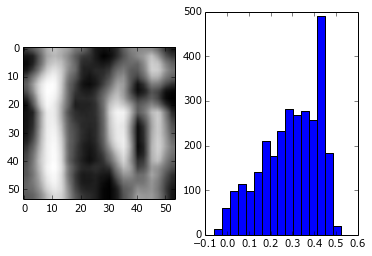

In [28]:
# Make sure the the data have mean of zero, 
# and normalize its scale to [-1, 1] along each feature

id = 9
test_img = test_dataset[id]
# display the normalized image
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(test_img.reshape(test_img.shape[0], test_img.shape[1]), cmap=plt.cm.Greys);
ax2.hist(np.reshape(test_img, 54 * 54), bins=20, range=[np.min(test_img) - 0.1, np.max(test_img) + 0.1]);

print 'Mean:', np.mean(test_img)
print 'Standard deviation:', np.std(test_img)

Label: [ 1  0  3 10 10]
Sequence length: 3


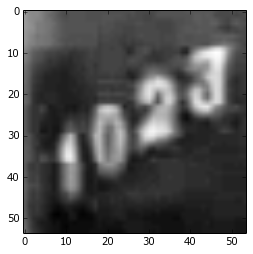

In [29]:
id = 152
img = test_dataset[id]
plt.imshow(img.reshape(54,54), cmap=plt.cm.Greys)

#print "Pred:", np.argmax(test_predictions[id],1)
print  "Label:", test_labels[id]
print  "Sequence length:", test_n_bboxes[id]

In [40]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Create a new interactive session that we'll use in
# subsequent code cells.
sess = tf.InteractiveSession()

# Use our newly created session as the default for 
# subsequent operations.
sess.as_default()

# Restore variables from disk.
saver.restore(sess, "./summary/" + "xaviel_init_model_lr_5e-05" + "/model.ckpt")
print("Model restored.")

Model restored.


[ 3  6 10 10 10]
(1, 54, 54, 1)
(1, 5, 11)
[[ 3  6 10 10 10]]
Done


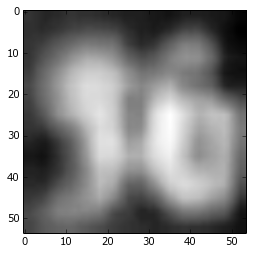

In [41]:
id = 13008
img = test_dataset[id]
print test_labels[id]
plt.imshow(img.reshape(MODEL_INPUT_IMAGE_SIZE,MODEL_INPUT_IMAGE_SIZE), cmap=plt.cm.Greys)

img  = np.reshape(img,(1,MODEL_INPUT_IMAGE_SIZE,MODEL_INPUT_IMAGE_SIZE,1))
print img.shape
seq = valid_pred.eval({tf_valid_dataset: img})

print seq.shape
print np.argmax(seq, 2)
print "Done"

In [42]:
test_predictions = valid_pred.eval({tf_valid_dataset: test_dataset})
labels = reformat(test_labels)
acc = transcription_accuracy(test_predictions, labels)
error = transcription_error(test_predictions, labels)

In [43]:
print('Test accuracy: %.1f%%' % acc)
print ('Test error: %.1f%%' % error)

Test accuracy: 94.2%
Test error: 5.8%


In [44]:
test_dataset_exp, test_labels_exp = get_batch_data_and_labels(0, TEST_DATASET_SIZE, TEST_IMAGE_SIZE, test_image_names, test_labels, test_bboxes, expand_bbox=True, training=False)

In [45]:
exp_test_predictions = valid_pred.eval({tf_valid_dataset: test_dataset_exp})
exp_labels = reformat(test_labels_exp)
acc = transcription_accuracy(exp_test_predictions, exp_labels)
error = transcription_error(exp_test_predictions, exp_labels)

In [46]:
print("Expanded test dataset.")
print('Test accuracy: %.1f%%' % acc)
print ('Test error: %.1f%%' % error)

Expanded test dataset.
Test accuracy: 88.3%
Test error: 11.7%


In [59]:
res = np.argmax(test_predictions,2) == np.argmax(labels,2)
wrogly_classified = []
id = 0
for r in res:
    if False in r:
        wrogly_classified.append(id)
    id += 1
print "Number of sequencences not (entirely) corrected classified:", len(wrogly_classified)

Number of sequencences not (entirely) corrected classified: 762


In [ ]:
main_errors = [8478, 2804, 1928, 9106, 2279, 9870, 12669, 10299, 5682, 2702, 5234, 10960]

print "Image shape:", labels.shape

id = 2701
img = test_dataset[id]
plt.imshow(img.reshape(MODEL_INPUT_IMAGE_SIZE,MODEL_INPUT_IMAGE_SIZE), cmap=plt.cm.Greys)

print "Predicted:", np.argmax(test_predictions[id],1)
print  "Label:", np.argmax(labels[id],1)

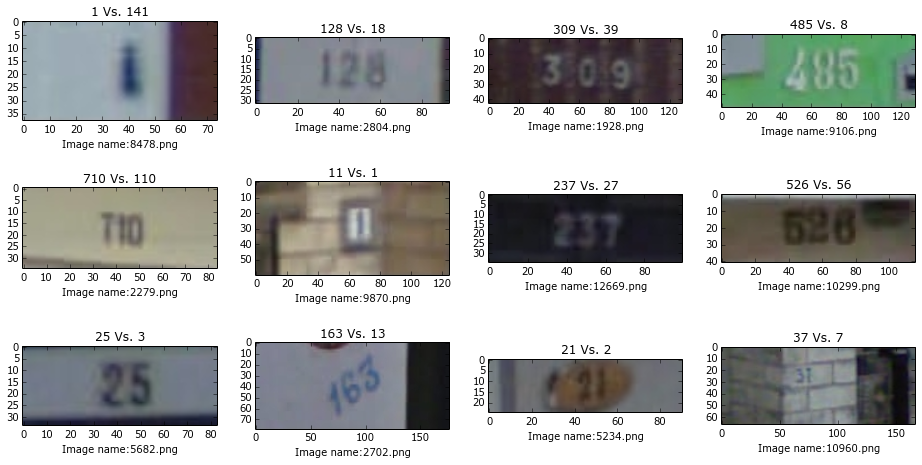

In [45]:
import matplotlib.image as mpimg
f, axarr = plt.subplots(3, 4, figsize=(16,8))

img_id = 0
for i in range(3):
    for j in range(4):
        id = main_errors[img_id]
        #id = random.randrange(0, test_dataset.shape[0])
        
        img = mpimg.imread('./test/' + str(id) + '.png')
        axarr[i, j].imshow(img);

        pred = np.argmax(test_predictions[id-1], 1)
        label = np.argmax(labels[id-1], 1)

        pred = pred[pred != 10]
        label = label[label != 10]

        pred = ''.join(str(e) for e in pred)
        label = ''.join(str(e) for e in label)

        axarr[i, j].set_title(pred + " Vs. " + label)
        axarr[i, j].set_xlabel('Image name:' + str(id) + '.png')
        img_id += 1
        
plt.show()

In [61]:
def compute_per_digit_error(predictions, labels, for_digit):
    index = 0
    batch = np.zeros(shape=(labels.shape[0],11), dtype=np.float32)
    for digit in labels:
        # print digit.shape
        batch[index] = digit[for_digit] # get s only the first digits of each image
        index += 1
        
    return error_rate(predictions[:,for_digit], batch)

def error_rate(predictions, labels):
  """Return the error rate and confusions."""
  correct = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
  total = predictions.shape[0]

  error = 100.0 - (100 * float(correct) / float(total))

  confusions = np.zeros([11, 11], np.float32)
  bundled = zip(np.argmax(predictions, 1), np.argmax(labels, 1))
  for predicted, actual in bundled:
    confusions[predicted, actual] += 1
    
  return error, confusions

print 'Done'

Done


In [62]:
def generate_confusion_matrices(confusions):
    plt.figure(figsize=(6.5,6.5))
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    plt.xticks(np.arange(NUM_LABELS))
    plt.yticks(np.arange(NUM_LABELS))        
    plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

    for i, cas in enumerate(confusions):
      for j, count in enumerate(cas):
        if count > 0:
          xoff = .06 * len(str(count))
          plt.text(j-xoff, i+.2, int(count), fontsize=10, color='white', ha='left', va='bottom')
        
    plt.show()

In [63]:
def get_digit_precision(confusions, for_label):
    return np.nan_to_num(round(confusions[for_label][for_label] / np.sum(confusions[for_label:for_label+1]),2))

def get_digit_recall(confusions, for_label):
    return np.nan_to_num(round(confusions[for_label][for_label] / np.sum(confusions[:,for_label:for_label+1]),2))

def get_digit_f1_score(precision, recall):
    return np.nan_to_num(round(2.0 * (precision * recall) / (precision + recall),2))

In [64]:
from ipy_table import *

In [65]:
# tables= []
def generate_statictics(confusions, for_label):
    row = []
    #for for_label in range(5):
    #for_label = 0
    precision = ["Precision"]
    recall = ["Recall"]
    f1_score = ["F1 Score"]
    header = ['']
    for for_digit in range(10):
        header.append(for_digit)

        pre = get_digit_precision(confusions, for_digit)
        precision.append(pre)

        rec = get_digit_recall(confusions, for_digit)
        recall.append(rec)

        f1 = get_digit_f1_score(pre, rec)
        f1_score.append(f1)

    table = [header, precision, recall, f1_score]
    # tables.append(row)
    return table

In [68]:
avg_char_percent = 0.0

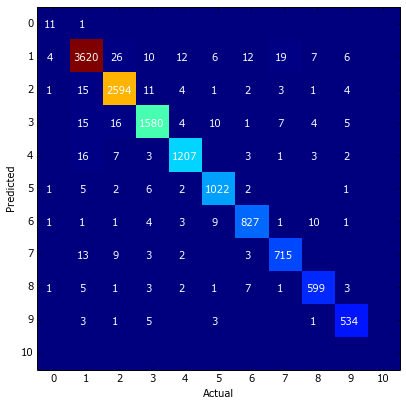

Error: 2.74716865626


,0,1,2,3,4,5,6,7,8,9
Precision,0.92,0.97,0.98,0.96,0.97,0.98,0.96,0.96,0.96,0.98
Recall,0.58,0.98,0.98,0.97,0.98,0.97,0.96,0.96,0.96,0.96
F1 Score,0.71,0.97,0.98,0.96,0.97,0.97,0.96,0.96,0.96,0.97


In [69]:
for_digit = 0
test_error, conf = compute_per_digit_error(test_predictions, labels, for_digit)
generate_confusion_matrices(conf)

print "Error:", test_error
avg_char_percent += 100.0 - test_error

table = generate_statictics(conf, for_digit)
make_table(table)
apply_theme('basic_both')
set_row_style(0,align='center')
set_global_style(float_format='%.2f')

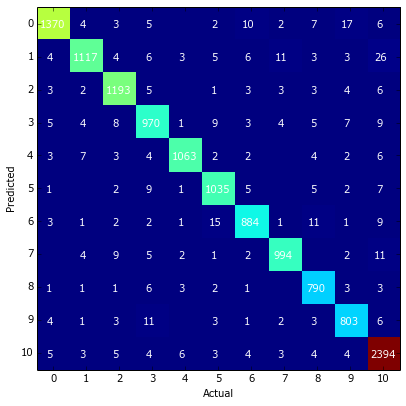

Error: 3.4817875727


,0,1,2,3,4,5,6,7,8,9
Precision,0.96,0.94,0.98,0.95,0.97,0.97,0.95,0.97,0.97,0.96
Recall,0.98,0.98,0.97,0.94,0.98,0.96,0.96,0.97,0.95,0.95
F1 Score,0.97,0.96,0.97,0.94,0.97,0.96,0.95,0.97,0.96,0.95


In [70]:
for_digit = 1
test_error, conf = compute_per_digit_error(test_predictions, labels, for_digit)

generate_confusion_matrices(conf)
print "Error:", test_error
avg_char_percent += 100.0 - test_error

table = generate_statictics(conf, for_digit)
make_table(table)
apply_theme('basic_both')
set_row_style(0,align='center')
set_global_style(float_format='%.2f')

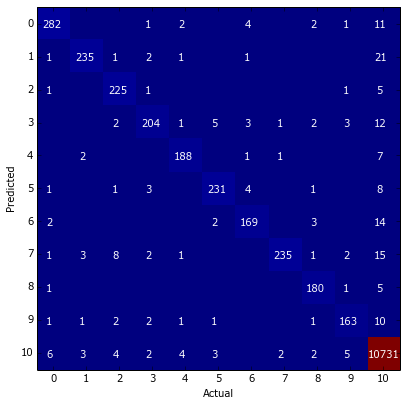

Error: 1.7217630854


,0,1,2,3,4,5,6,7,8,9
Precision,0.93,0.90,0.97,0.88,0.94,0.93,0.89,0.88,0.96,0.90
Recall,0.95,0.96,0.93,0.94,0.95,0.95,0.93,0.98,0.94,0.93
F1 Score,0.94,0.93,0.95,0.91,0.94,0.94,0.91,0.93,0.95,0.91


In [71]:
for_digit = 2
test_error, conf = compute_per_digit_error(test_predictions, labels, for_digit)

generate_confusion_matrices(conf)
print "Error:", test_error
avg_char_percent += 100.0 - test_error

table = generate_statictics(conf, for_digit)
make_table(table)
apply_theme('basic_both')
set_row_style(0,align='center')
set_global_style(float_format='%.2f')

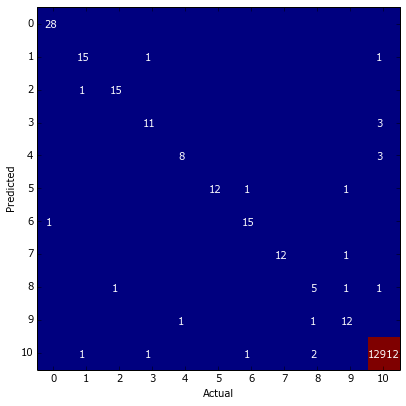

Error: 0.17600244873


,0,1,2,3,4,5,6,7,8,9
Precision,1.00,0.88,0.94,0.79,0.73,0.86,0.94,0.92,0.63,0.86
Recall,0.97,0.88,0.94,0.85,0.89,1.00,0.88,1.00,0.63,0.80
F1 Score,0.98,0.88,0.94,0.82,0.80,0.92,0.91,0.96,0.63,0.83


In [72]:
for_digit = 3
test_error, conf = compute_per_digit_error(test_predictions, labels, for_digit)

generate_confusion_matrices(conf)
print "Error:", test_error
avg_char_percent += 100.0 - test_error

table = generate_statictics(conf, for_digit)
make_table(table)
apply_theme('basic_both')
set_row_style(0,align='center')
set_global_style(float_format='%.2f')

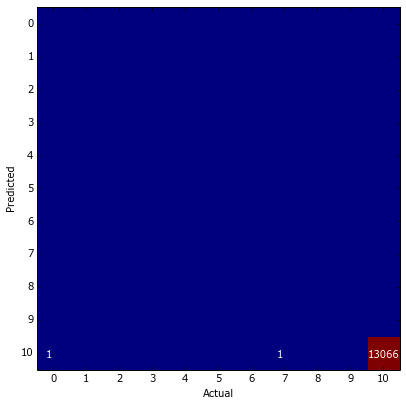

Error: 0.0153045607591


,0,1,2,3,4,5,6,7,8,9
Precision,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Recall,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
F1 Score,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [73]:
for_digit = 4
test_error, conf = compute_per_digit_error(test_predictions, labels, for_digit)

generate_confusion_matrices(conf)
print "Error:", test_error
avg_char_percent += 100.0 - test_error

table = generate_statictics(conf, for_digit)
make_table(table)
apply_theme('basic_both')
set_row_style(0,align='center')
set_global_style(float_format='%.2f')

In [74]:
print "character-level acc:", avg_char_percent / 5.0

character-level acc: 98.3715947352
